In [0]:
from google.colab import drive
drive.mount('/content/gdrive') 

In [0]:
import torch
from torch.utils import data
import pandas as pd
import albumentations
from albumentations import torch as AT
from tqdm import tqdm
import math
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline 
import torch.nn.functional as F
#from albumentations import pytorch as AT

In [0]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [4]:
%cd "/content/gdrive/My Drive/Colab Notebooks/FER2013-Kaggle"

/content/gdrive/My Drive/Colab Notebooks/FER2013-Kaggle


In [5]:
df=pd.read_csv('fer2013.csv')
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [6]:
df['Usage'].unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [7]:
print(len(df[df['Usage']=='Training']))
print(len(df[df['Usage']=='PublicTest']))
print(len(df[df['Usage']=='PrivateTest']))

28709
3589
3589


In [0]:
df['pixelss']=[[int(y) for y in x.split()] for x in df['pixels']]

In [9]:
df.head()

,emotion,pixels,Usage,pixelss
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4..."
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ..."
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training,"[231, 212, 156, 164, 174, 138, 161, 173, 182, ..."
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2..."
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23..."


In [0]:
df_train=df[df['Usage']=='Training']
df_valid=df[df['Usage']=='PrivateTest']
df_test=df[df['Usage']=='PublicTest']

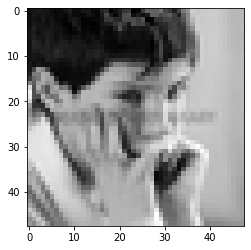

In [11]:
z=np.array(df_train['pixelss'][3])
zz=z.reshape(48,48)
plt.imshow(zz, interpolation='nearest',cmap='gray')
plt.show()

In [0]:
part={}
#train_data_length=len(df_train)
#ids=list(range(0,train_data_length))
#x=math.ceil(0.8*train_data_length)
part['train']= list(range(0,len(df_train)))
part['valid']= list(range(0,len(df_valid)))
part['test']= list(range(0,len(df_test)))
train_labels=df_train['emotion'].tolist()
valid_labels=df_valid['emotion'].tolist()
test_labels=df_test['emotion'].tolist()

In [13]:
df_valid['pixelss']

32298    [170, 118, 101, 88, 88, 75, 78, 82, 66, 74, 68...
32299    [7, 5, 8, 6, 7, 3, 2, 6, 5, 4, 4, 5, 7, 5, 5, ...
32300    [232, 240, 241, 239, 237, 235, 246, 117, 24, 2...
32301    [200, 197, 149, 139, 156, 89, 111, 58, 62, 95,...
32302    [40, 28, 33, 56, 45, 33, 31, 78, 152, 194, 200...
                               ...                        
35882    [50, 36, 17, 22, 23, 29, 33, 39, 34, 37, 37, 3...
35883    [178, 174, 172, 173, 181, 188, 191, 194, 196, ...
35884    [17, 17, 16, 23, 28, 22, 19, 17, 25, 26, 20, 2...
35885    [30, 28, 28, 29, 31, 30, 42, 68, 79, 81, 77, 6...
35886    [19, 13, 14, 12, 13, 16, 21, 33, 50, 57, 71, 8...
Name: pixelss, Length: 3589, dtype: object

In [0]:
class Dataset(data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, dff, transforms):
        'Initialization'
        self.transforms = transforms
        self.dff=dff

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.dff)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        #ID = self.list_IDs[index]

        # Load data and get label
        X = self.dff.iloc[index]['pixelss']
        X = np.array(X).reshape(48,48,1)
        y = self.dff.iloc[index]['emotion']

        if self.transforms:
          X = self.transforms(X)
        
        X = torch.cat((X,X,X),0)

        return X, y

In [0]:
params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 10}

In [0]:
class AlbumentationWrapper(object):
    def __init__(self,split):
        self.split=split
        self.aug=albumentations.Compose([                                         
    albumentations.Normalize((0.5), (0.5)),
    AT.ToTensor()
    ])
	
        if self.split=='train':
            self.aug=albumentations.Compose([
                                             
            #albumentations.Resize(48,48),
    albumentations.HorizontalFlip(),
    #albumentations.RandomBrightness(),
    #albumentations.ShiftScaleRotate(rotate_limit=15, scale_limit=0.10),
    #albumentations.HueSaturationValue(),
    albumentations.Cutout(2,2,2,0.5),
    albumentations.GaussNoise(),
    #albumentations.ElasticTransform(),    
    albumentations.Normalize((0.5), (0.5)),
    AT.ToTensor()    
    ])
            
    def __call__(self,img):
        #img = np.array(img)
        img = self.aug(image=img)['image']
        return img

In [0]:
train_transforms , validation_transforms=AlbumentationWrapper('train'), AlbumentationWrapper('test')

In [0]:
training_set = Dataset(df_train, train_transforms)
training_generator = data.DataLoader(training_set, **params)

validation_set = Dataset(df_valid, validation_transforms)
validation_generator = data.DataLoader(validation_set, **params)

test_set = Dataset(df_test, validation_transforms)
test_generator = data.DataLoader(test_set, **params)

In [0]:
import torchvision.models as models
from torch import nn
from torchsummary import summary
from collections import OrderedDict
import torch.optim as optim

In [0]:
def model_params(model, input_size,device):
  model = model.to(device)
  summary(model, input_size)

In [0]:
#model_params(model,(3,28,28),device)

In [0]:
def plot(train_losses,train_acc,test_losses,test_acc, label):
  fig, axs = plt.subplots(1,2,figsize=(20,8))
  axs[0].plot(test_losses, label=label)
  axs[0].set_title("Test Loss")
  axs[1].plot(test_acc, label=label)
  axs[1].set_title("Test Accuracy")

In [0]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [0]:
def train(model, train_loader, optimizer,scheduler):
  model.train()
  pbar = tqdm(train_loader)
  running_loss = 0.0
  correct = 0
  processed = 0
  criterion = nn.CrossEntropyLoss()

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    y_pred = model(data)
    loss = criterion(y_pred, target)
    running_loss += loss.item()
    train_loss.append(loss)
    loss.backward()
    optimizer.step()
    scheduler.step()

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    #pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f} running_loss={running_loss} threshold={best_loss*(0.996)}')
    train_acc.append(100*correct/processed)
    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} le={get_lr(optimizer)} Accuracy={100*correct/processed:0.2f}')

In [0]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            new_target=target.view_as(pred)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    valid_loss.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    valid_acc.append(100. * correct / len(test_loader.dataset))

In [0]:
class Net(nn.Module):
    def __init__(self, dropout):
        super(Net, self).__init__()
        dropout_value = dropout
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            # nn.Dropout(dropout_value)
        ) 

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            # nn.Dropout(dropout_value)            
        ) 

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 24 RF=7
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            # nn.Dropout(dropout_value)            
        ) 

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(256),
        ) 

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(1, 1), padding=1 , bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            # nn.Dropout(dropout_value)            
        ) 

        # TRANSITION BLOCK 2
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 12 RF=20

        # CONVOLUTION BLOCK 2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            # nn.Dropout(dropout_value)            
        ) 

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            # nn.Dropout(dropout_value)            
        )

        # TRANSITION BLOCK 3
        self.pool3 = nn.MaxPool2d(2, 2) # output_size =6 RF=32

        self.convblock8 = nn.Sequential(
             nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=(3, 3), padding=1, bias=False),
             nn.ReLU(),
             nn.BatchNorm2d(512),
             # nn.Dropout(dropout_value)            
         ) 

        self.convblock9 = nn.Sequential(
             nn.Conv2d(in_channels=512, out_channels=256, kernel_size=(3, 3), padding=0, bias=False),
             nn.ReLU(),
             nn.BatchNorm2d(256),
             # nn.Dropout(dropout_value)            
         )
        # self.pool2 = nn.MaxPool2d(2, 2) # output_size = 2
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) 
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=7, kernel_size=(1, 1), padding=0, bias=False)
        ) 

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)        
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.pool2(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.pool3(x)   
        x = self.convblock8(x) 
        x = self.convblock9(x)    
        x = self.gap(x)
        x = self.convblock10(x)
        x = x.view(-1, 7)
        return F.log_softmax(x, dim=-1)

  0%|          | 0/449 [00:00<?, ?it/s]

EPOCH: 0 LR: 0.0019999999999999983 


Loss=1.8162355422973633 Batch_id=448 le=0.0030634337130716477 Accuracy=28.82: 100%|██████████| 449/449 [02:15<00:00,  3.32it/s]
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 1562/3589 (43.52%)

EPOCH: 1 LR: 0.0030634337130716477 


Loss=1.5955754518508911 Batch_id=448 le=0.006002425682931637 Accuracy=36.08: 100%|██████████| 449/449 [02:16<00:00,  3.28it/s]
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 1802/3589 (50.21%)

EPOCH: 2 LR: 0.006002425682931637 


Loss=1.6397616863250732 Batch_id=448 le=0.010122437433314183 Accuracy=38.28: 100%|██████████| 449/449 [02:16<00:00,  3.28it/s]
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 1860/3589 (51.83%)

EPOCH: 3 LR: 0.010122437433314183 


Loss=1.664178490638733 Batch_id=448 le=0.014449833543417487 Accuracy=39.25: 100%|██████████| 449/449 [02:16<00:00,  3.28it/s]
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 1924/3589 (53.61%)

EPOCH: 4 LR: 0.014449833543417487 


Loss=1.7090476751327515 Batch_id=448 le=0.017961969810286214 Accuracy=40.27: 100%|██████████| 449/449 [02:16<00:00,  3.28it/s]
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 2002/3589 (55.78%)

EPOCH: 5 LR: 0.017961969810286214 


Loss=1.4405971765518188 Batch_id=448 le=0.019828863098122623 Accuracy=41.12: 100%|██████████| 449/449 [02:16<00:00,  3.28it/s]
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 2102/3589 (58.57%)

EPOCH: 6 LR: 0.019828863098122623 


Loss=1.540640950202942 Batch_id=448 le=0.01997270340423158 Accuracy=42.03: 100%|██████████| 449/449 [02:16<00:00,  3.29it/s]
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 2028/3589 (56.51%)

EPOCH: 7 LR: 0.01997270340423158 


Loss=1.2844151258468628 Batch_id=448 le=0.01980732115328246 Accuracy=42.88: 100%|██████████| 449/449 [02:16<00:00,  3.28it/s]
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 2165/3589 (60.32%)

EPOCH: 8 LR: 0.01980732115328246 


Loss=1.4906305074691772 Batch_id=448 le=0.019494429167601215 Accuracy=43.53: 100%|██████████| 449/449 [02:16<00:00,  3.29it/s]
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 2164/3589 (60.30%)

EPOCH: 9 LR: 0.019494429167601215 


Loss=1.4050627946853638 Batch_id=448 le=0.019038733633893166 Accuracy=43.99: 100%|██████████| 449/449 [02:16<00:00,  3.30it/s]
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Accuracy: 2162/3589 (60.24%)

EPOCH: 10 LR: 0.019038733633893166 


Loss=1.653092622756958 Batch_id=448 le=0.018447088637147856 Accuracy=44.20: 100%|██████████| 449/449 [02:15<00:00,  3.31it/s]
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 2185/3589 (60.88%)

EPOCH: 11 LR: 0.018447088637147856 


Loss=1.3488965034484863 Batch_id=448 le=0.017728393068821027 Accuracy=45.52: 100%|██████████| 449/449 [02:16<00:00,  3.30it/s]
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0161, Accuracy: 2233/3589 (62.22%)

EPOCH: 12 LR: 0.017728393068821027 


Loss=1.3903796672821045 Batch_id=448 le=0.016893456779224002 Accuracy=45.55: 100%|██████████| 449/449 [02:15<00:00,  3.31it/s]
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0160, Accuracy: 2227/3589 (62.05%)

EPOCH: 13 LR: 0.016893456779224002 


Loss=1.2840741872787476 Batch_id=448 le=0.015954837987313175 Accuracy=46.12: 100%|██████████| 449/449 [02:15<00:00,  3.31it/s]
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Accuracy: 2220/3589 (61.86%)

EPOCH: 14 LR: 0.015954837987313175 


Loss=1.64229416847229 Batch_id=448 le=0.014926654393387674 Accuracy=46.99: 100%|██████████| 449/449 [02:15<00:00,  3.32it/s]
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0160, Accuracy: 2279/3589 (63.50%)

EPOCH: 15 LR: 0.014926654393387674 


Loss=1.1482453346252441 Batch_id=448 le=0.013824370835736084 Accuracy=47.49: 100%|██████████| 449/449 [02:15<00:00,  3.31it/s]
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0151, Accuracy: 2322/3589 (64.70%)

EPOCH: 16 LR: 0.013824370835736084 


Loss=1.2221027612686157 Batch_id=448 le=0.012664566685073859 Accuracy=47.90: 100%|██████████| 449/449 [02:15<00:00,  3.32it/s]
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0159, Accuracy: 2318/3589 (64.59%)

EPOCH: 17 LR: 0.012664566685073859 


Loss=1.5824140310287476 Batch_id=448 le=0.011464686475375662 Accuracy=49.09: 100%|██████████| 449/449 [02:15<00:00,  3.31it/s]
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0154, Accuracy: 2271/3589 (63.28%)

EPOCH: 18 LR: 0.011464686475375662 


Loss=1.3573566675186157 Batch_id=448 le=0.010242777521846942 Accuracy=49.73: 100%|██████████| 449/449 [02:14<00:00,  3.33it/s]
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0159, Accuracy: 2278/3589 (63.47%)

EPOCH: 19 LR: 0.010242777521846942 


Loss=1.2509315013885498 Batch_id=448 le=0.009017218472504782 Accuracy=50.93: 100%|██████████| 449/449 [02:15<00:00,  3.32it/s]
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0162, Accuracy: 2285/3589 (63.67%)

EPOCH: 20 LR: 0.009017218472504782 


Loss=1.180890679359436 Batch_id=448 le=0.007806442876204813 Accuracy=52.36: 100%|██████████| 449/449 [02:14<00:00,  3.33it/s]
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0156, Accuracy: 2354/3589 (65.59%)

EPOCH: 21 LR: 0.007806442876204813 


Loss=1.2218623161315918 Batch_id=448 le=0.006628661924908432 Accuracy=53.21: 100%|██████████| 449/449 [02:14<00:00,  3.33it/s]
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0156, Accuracy: 2339/3589 (65.17%)

EPOCH: 22 LR: 0.006628661924908432 


Loss=0.9456607699394226 Batch_id=448 le=0.005501590540404688 Accuracy=54.36: 100%|██████████| 449/449 [02:14<00:00,  3.33it/s]
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0159, Accuracy: 2360/3589 (65.76%)

EPOCH: 23 LR: 0.005501590540404688 


Loss=1.0514447689056396 Batch_id=448 le=0.004442180925397468 Accuracy=55.65: 100%|██████████| 449/449 [02:15<00:00,  3.32it/s]
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 2388/3589 (66.54%)

EPOCH: 24 LR: 0.004442180925397468 


Loss=1.1648427248001099 Batch_id=448 le=0.003466367586597686 Accuracy=57.19: 100%|██████████| 449/449 [02:14<00:00,  3.33it/s]
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 2404/3589 (66.98%)

EPOCH: 25 LR: 0.003466367586597686 


Loss=1.1350675821304321 Batch_id=448 le=0.0025888276649104597 Accuracy=58.87: 100%|██████████| 449/449 [02:14<00:00,  3.34it/s]
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 2393/3589 (66.68%)

EPOCH: 26 LR: 0.0025888276649104597 


Loss=1.1061333417892456 Batch_id=448 le=0.0018227601775743923 Accuracy=59.19: 100%|██████████| 449/449 [02:14<00:00,  3.33it/s]
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0167, Accuracy: 2430/3589 (67.71%)

EPOCH: 27 LR: 0.0018227601775743923 


Loss=0.9230332374572754 Batch_id=448 le=0.0011796874926566104 Accuracy=60.10: 100%|██████████| 449/449 [02:15<00:00,  3.33it/s]
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 2426/3589 (67.60%)

EPOCH: 28 LR: 0.0011796874926566104 


Loss=0.7695614695549011 Batch_id=448 le=0.0006692820219119917 Accuracy=60.94: 100%|██████████| 449/449 [02:14<00:00,  3.34it/s]
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 2453/3589 (68.35%)

EPOCH: 29 LR: 0.0006692820219119917 


Loss=0.9851700067520142 Batch_id=448 le=0.0002992207387072647 Accuracy=60.78: 100%|██████████| 449/449 [02:14<00:00,  3.33it/s]
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 2449/3589 (68.24%)

EPOCH: 30 LR: 0.0002992207387072647 


Loss=1.008679986000061 Batch_id=448 le=7.506970919582438e-05 Accuracy=61.11: 100%|██████████| 449/449 [02:14<00:00,  3.35it/s]
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 2455/3589 (68.40%)

EPOCH: 31 LR: 7.506970919582438e-05 


Loss=0.7571970224380493 Batch_id=448 le=2.0037350187915896e-07 Accuracy=61.61: 100%|██████████| 449/449 [02:14<00:00,  3.33it/s]



Test set: Average loss: 0.0172, Accuracy: 2456/3589 (68.43%)



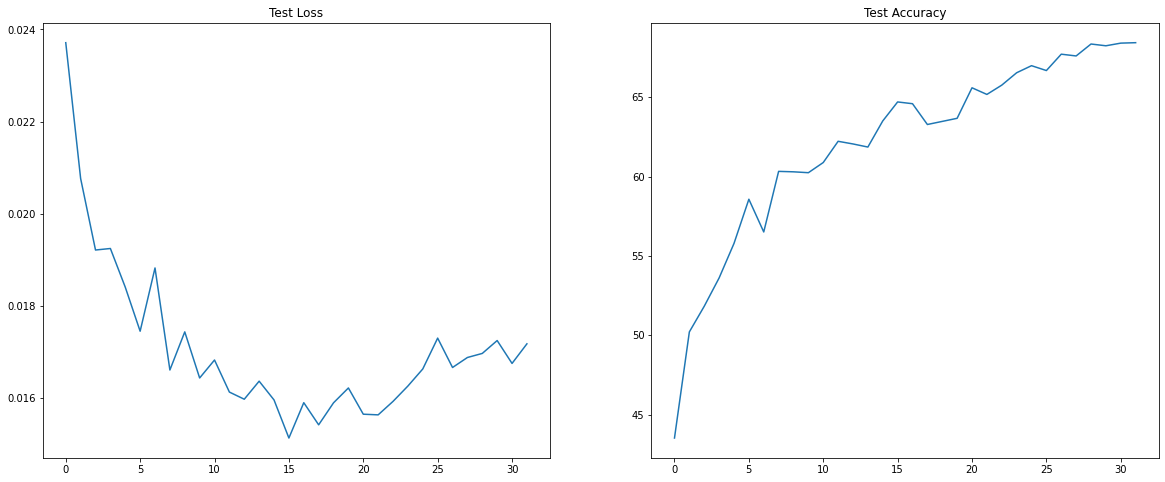

In [27]:
model=Net(1.0)
model.to(device)
epochs=32
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9, weight_decay=9e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.02, steps_per_epoch=len(training_generator), pct_start=0.2, div_factor=10, cycle_momentum=False, epochs=epochs)

input_size=(3,48,48)
train_acc = []
train_loss = []
valid_acc = []
valid_loss = []
for epoch in range(epochs):
    print("EPOCH: %s LR: %s " % (epoch, get_lr(optimizer)))
    train(model, training_generator, optimizer,scheduler)
    test(model, validation_generator)
    #scheduler.step()
plot(train_loss,train_acc, valid_loss, valid_acc, 'Loss & Accuracy')

In [28]:
test(model, test_generator)


Test set: Average loss: 0.0177, Accuracy: 2443/3589 (68.07%)

